<a href="https://colab.research.google.com/github/dsklnr/Airline_Baggage/blob/main/ML_Assignment_4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import tarfile
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import make_classification
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder,StandardScaler, Normalizer
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import SGDClassifier
from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bootstrap_point632_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=matplotlib.cbook.mplDeprecation)

<ipython-input-1-5d67f4157358>:22: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.simplefilter(action='ignore', category=matplotlib.cbook.mplDeprecation)


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
current_folder = os.getcwd()


# data = sklearn.datasets.load_svmlight_files(['labeledBow.feat'])

def load_aclImdb_file(filename):
    ''' filename is id_rating

        returns a dict object, {id, rating, text}
    '''
    id,rating,txt = re.split('[_.]',filename)
    with open(filename,'r',encoding="utf8") as f:
        text_of_file = f.read()

    return {'id':id,'rating':rating,'text':text_of_file}


data_dicts=[]
for cat in ['neg','pos']:

    os.chdir(os.path.join('/content/drive/My Drive/aclmdb/train/', cat))

    for file in os.listdir('.'):
        dd = load_aclImdb_file(file)
        dd.update({'cat':cat})
        data_dicts.append(dd)

acl_imdb_data = pd.DataFrame(data_dicts)

# first take on this...
corpus = acl_imdb_data['text']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

# MemoryError: Unable to allocate 12.5 GiB for an array with shape
# (76065, 22110) and data type int64

features = vectorizer.get_feature_names_out()
word_count_df=pd.DataFrame.sparse.from_spmatrix(X,columns=features,
                                                index=corpus.index)

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(acl_imdb_data['cat'])
labels = pd.Series(lb.transform(acl_imdb_data['cat']).reshape(-1))

labels.name = 'LABELS_FOR_CLASSIFICATION'

In [4]:
# Show the first 5 rows
acl_imdb_data.head()

,id,rating,text,cat
0,11523,2,"""Igor and the Lunatics"" is a totally inept and...",neg
1,11374,2,I couldn't relate to this film. It failed to e...,neg
2,11447,1,Quite possibly the worst movie I've ever seen;...,neg
3,11914,2,Shiri Appleby is the cutest little embodiment ...,neg
4,11510,1,It's not my fault. My girlfriend made me watch...,neg


Generate classification data using make_classification from sklearn.datasets

In [5]:
X, y = make_classification(n_features=2, n_redundant=0,
                           n_informative=2,random_state=1,
                           n_clusters_per_class=1)

Use SGDClassifier to train classifiers using different loss functions: log, hinge, and perceptron.
Visualize the trained classifiers using plot_decision_regions(X, y, clf=model,
legend=2)from the mlextend package. Plot the decision region for each of the three loss
functions

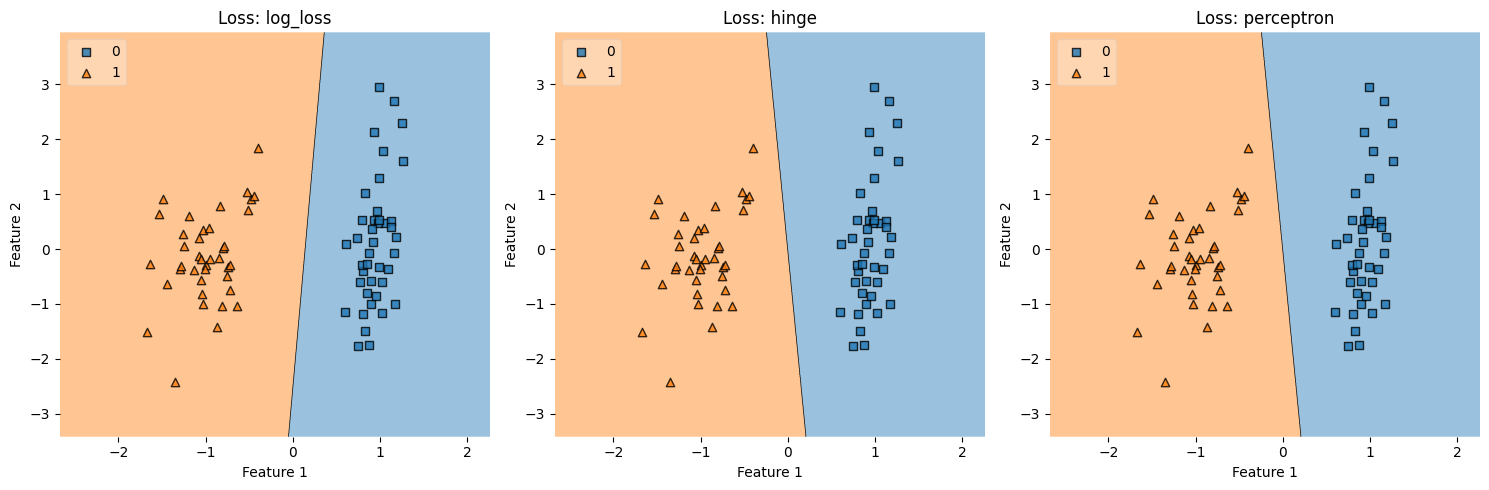

In [6]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define loss functions
loss_functions = ['log_loss', 'hinge', 'perceptron']
classifiers = {}

# Train classifiers with different loss functions
for loss in loss_functions:
    clf = SGDClassifier(loss=loss, max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    classifiers[loss] = clf

# Set up the figure and axis for plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot decision regions for each classifier
for ax, (loss, clf) in zip(axes, classifiers.items()):
    plot_decision_regions(X_train, y_train, clf=clf, ax=ax, legend=2)
    ax.set_title(f"Loss: {loss}")
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

Now, create a larger classification dataset. You will use cross_val_score from scikit-learn and
compare this to bootstrap_scores from mlextend

In [16]:
# Use a larger dataset
X, y = make_classification(n_samples=10000, n_features=20,
                           n_redundant=0, n_informative=20,
                           random_state=1, n_clusters_per_class=1)

With your classifier in a variable called model (using SGGClassifier, as before), get the accuracy scores

In [27]:
# Lists to store results
scores_list = []
avg_list = []
bootstrap_scores_dict = {loss: [] for loss in loss_functions}

# Iterate over loss functions
for loss in loss_functions:
    # Create and train the model
    model = SGDClassifier(loss=loss, max_iter=1000, random_state=42)

    # Compute cross-validation scores
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

    # Compute bootstrap scores
    bootstrap_scores = bootstrap_point632_score(model, X, y, method='oob', n_splits=100)

    # Store scores and averages
    scores_list.append({'Loss Function': loss, 'CV Scores': cv_scores, 'Bootstrap Scores': bootstrap_scores})
    avg_list.append({'Loss Function': loss,
                     'Mean CV Accuracy': np.mean(cv_scores),
                     'Mean Bootstrap Accuracy': np.mean(bootstrap_scores)})

    # Store bootstrap scores for plotting
    bootstrap_scores_dict[loss] = bootstrap_scores

Create a table with the average of each cross-validation score and the average of the bootstrap
scores.

In [28]:
# Create DataFrames from the results
scores_df = pd.DataFrame(scores_list)
avg_df = pd.DataFrame(avg_list)

# Display the accuracy scores
scores_df

,Loss Function,CV Scores,Bootstrap Scores
0,log_loss,"[0.9005, 0.899, 0.911, 0.902, 0.898]","[0.9020884187686466, 0.9052208835341365, 0.888..."
1,hinge,"[0.89, 0.9065, 0.9065, 0.898, 0.89]","[0.9039301310043668, 0.8989063750333423, 0.878..."
2,perceptron,"[0.891, 0.8815, 0.859, 0.8535, 0.875]","[0.8790083535435192, 0.890133916370593, 0.8750..."


In [29]:
# Show the mean accuracy scores
avg_df

,Loss Function,Mean CV Accuracy,Mean Bootstrap Accuracy
0,log_loss,0.9021,0.902872
1,hinge,0.8982,0.896127
2,perceptron,0.8720,0.877094


Use distplot from the seaborn package to plot your bootstrap samples

<ipython-input-30-eae7f5ff9a9f>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(bootstrap_scores_dict[loss], hist=True, kde=True,
<ipython-input-30-eae7f5ff9a9f>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(bootstrap_scores_dict[loss], hist=True, kde=True,
<ipython-input-30-eae7f5ff9a9f>:4:

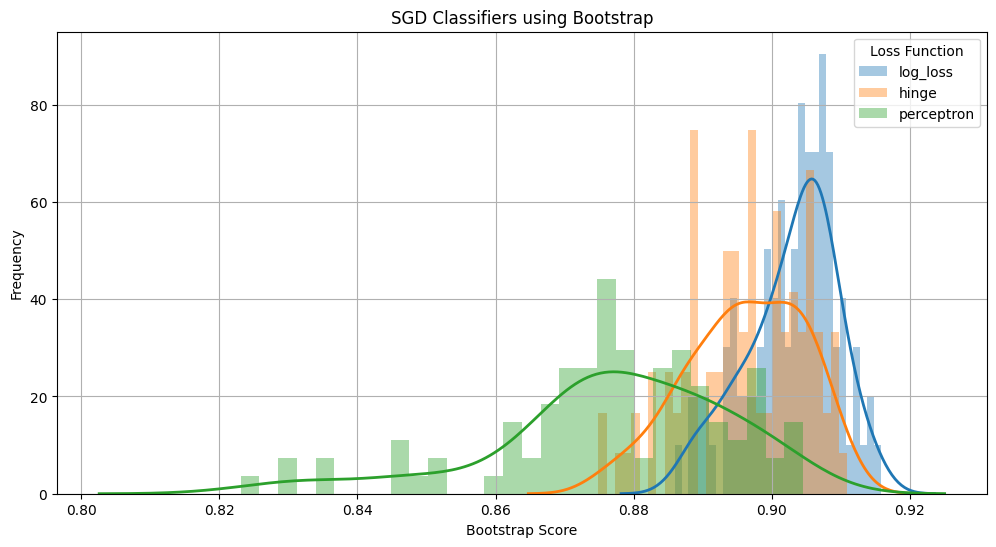

In [30]:
# Plot bootstrap scores distributions using seaborn's distplot
plt.figure(figsize=(12, 6))
for loss in loss_functions:
    sns.distplot(bootstrap_scores_dict[loss], hist=True, kde=True,
                 bins=30, label=loss, kde_kws={'linewidth': 2})
plt.title('SGD Classifiers using Bootstrap')
plt.xlabel('Bootstrap Score')
plt.ylabel('Frequency')
plt.legend(title='Loss Function')
plt.grid(True)
plt.show()

Finally, you will look at the importance of setting the regularization parameter. Create a
database with only two informative features

In [12]:
# Generate a dataset with 2 informative features
X, y = make_classification(n_samples=1000, n_features=2000,
                           n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)

Train a regularized classifier using ‘log’ as the loss function. Try both types of regularization ‘L1’
and ‘L2’ and sweep alpha over a range from: [0.0001,0.001,0.01,0.1,1,10,100,1000]. Use
fivefold cross-validation to measure accuracy. Create a table of accuracy indexed by alpha, and
use this table to plot the accuracy for both types of regularization

In [13]:
# Define a range of alpha values
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Prepare lists to store results
results = []

# Evaluate 'l1' regularization
for alpha in alpha_values:
    model = SGDClassifier(loss='log_loss', penalty='l1',
                          alpha=alpha, max_iter=1000, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    mean_accuracy = np.mean(cv_scores)
    results.append({'Alpha': alpha, 'Penalty': 'l1',
                    'Mean Accuracy': mean_accuracy})

# Evaluate 'l2' regularization
for alpha in alpha_values:
    model = SGDClassifier(loss='log_loss', penalty='l2', alpha=alpha,
                          max_iter=1000, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    mean_accuracy = np.mean(cv_scores)
    results.append({'Alpha': alpha, 'Penalty': 'l2',
                    'Mean Accuracy': mean_accuracy})

# Create a DataFrame to store the results
results_df = pd.DataFrame(results)
results_df

,Alpha,Penalty,Mean Accuracy
0,0.0001,l1,0.654
1,0.0010,l1,0.658
2,0.0100,l1,0.657
3,0.1000,l1,0.896
4,1.0000,l1,0.503
5,10.0000,l1,0.503
6,100.0000,l1,0.503
7,1000.0000,l1,0.503
8,0.0001,l2,0.651
9,0.0010,l2,0.656


In [14]:
# Pivot the table to facilitate plotting
pivot_table = results_df.pivot(index='Alpha', columns='Penalty',
                               values='Mean Accuracy')
pivot_table

Penalty,l1,l2
Alpha,,
0.0001,0.654,0.651
0.0010,0.658,0.656
0.0100,0.657,0.659
0.1000,0.896,0.673
1.0000,0.503,0.676
10.0000,0.503,0.526
100.0000,0.503,0.503
1000.0000,0.503,0.503


<Figure size 1000x600 with 0 Axes>

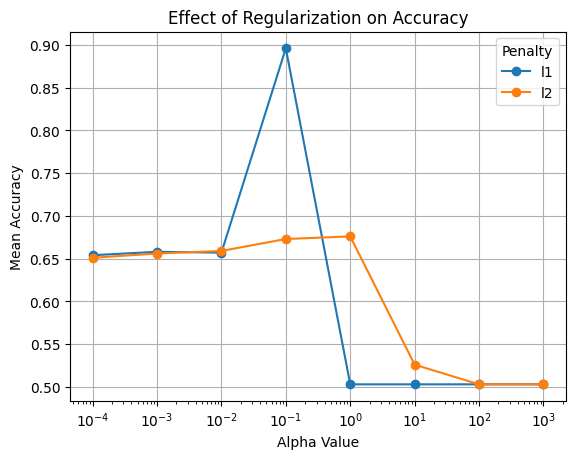

In [15]:
pivot_table# Plot the results
plt.figure(figsize=(10, 6))
pivot_table.plot(marker='o')
plt.title('Effect of Regularization on Accuracy')
plt.xlabel('Alpha Value')
plt.ylabel('Mean Accuracy')
plt.xscale('log')
plt.legend(title='Penalty')
plt.grid(True)
plt.show()